In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import blackmanharris, fftconvolve
%matplotlib inline
pd.options.display.precision = 15
from numpy.fft import rfft, irfft
from numpy import argmax, sqrt, mean, absolute, linspace, log10, logical_and, average, diff, correlate, nonzero
from scipy.signal import blackmanharris, fftconvolve
import time
import sys
import numpy as np
from utils import freq_from_crossings, freq_from_fft, freq_from_autocorr, parabolic

In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000

CPU times: user 1min 19s, sys: 3.38 s, total: 1min 23s
Wall time: 1min 23s


In [3]:
data = train['acoustic_data'].values[:150000]

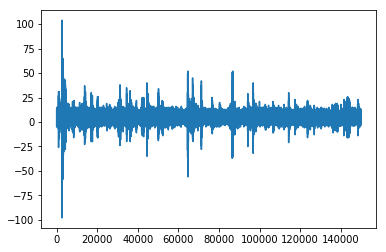

In [4]:
plt.figure()
plt.plot(data)
plt.show()

Calculating frequency from zero crossings:


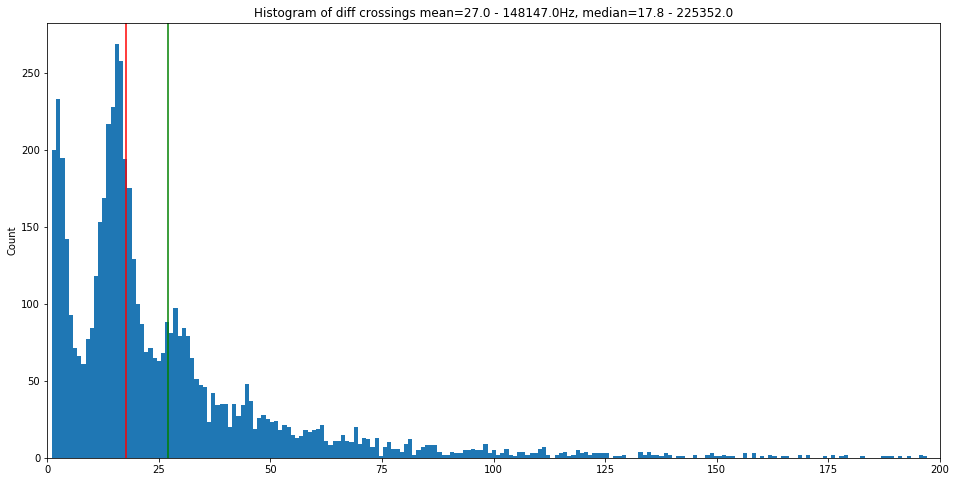

225352.0 Hz
Calculating frequency from FFT:


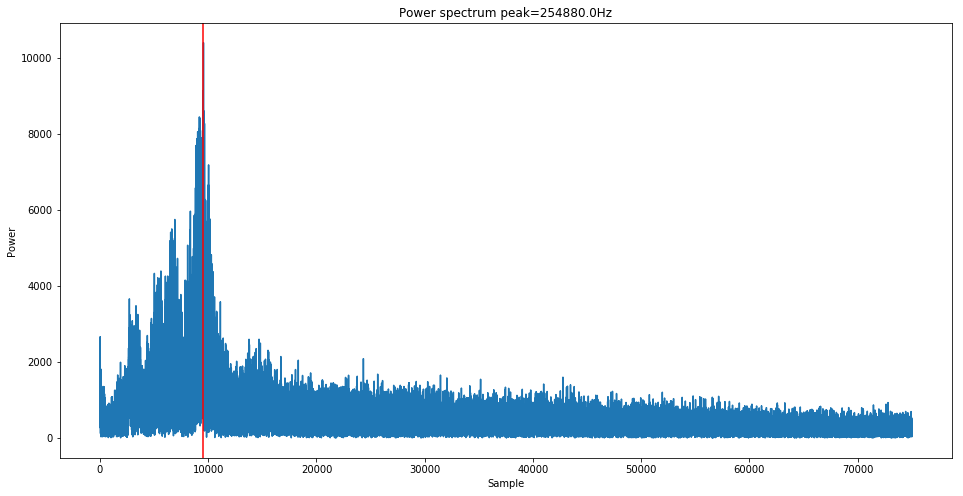

254880.0 Hz


In [5]:
print('Calculating frequency from zero crossings:')
print(f'{round(freq_from_crossings(data, fs))} Hz')

print('Calculating frequency from FFT:')
print(f'{round(freq_from_fft(data, fs))} Hz')

#print('Calculating frequency from autocorrelation:')
#print(f'{freq_from_autocorr(data, fs)} Hz')

## Playground with zero-crossing method

In [6]:
"""Estimate frequency by counting zero crossings"""

# Find all indices right before a rising-edge zero crossing
idx = np.nonzero((data[1:] >= 0) & (data[:-1] < 0))

# More accurate, using linear interpolation to find intersample 
# zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
crossings = [i - data[i] / (data[i+1] - data[i]) for i in idx]
diff_crossings = np.diff(crossings[0])
min_diff_crossings = np.min(diff_crossings)
max_diff_crossings = np.max(diff_crossings)
mean_diff_crossings = np.mean(diff_crossings)
median_diff_crossings = np.median(diff_crossings)                       

In [7]:
mean_freq = fs / mean_diff_crossings
median_freq = fs / median_diff_crossings

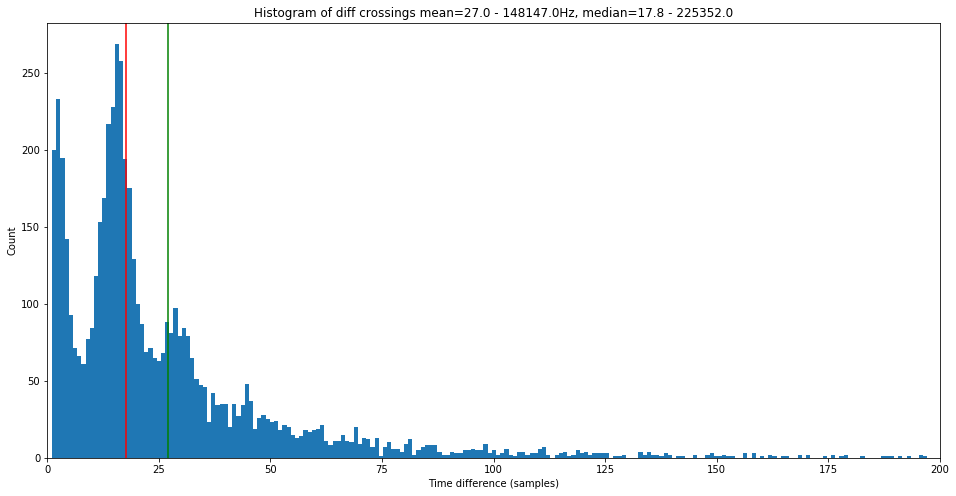

In [8]:
plt.figure(figsize=(16, 8))
plt.hist(diff_crossings, bins=500)
plt.title(f'Histogram of diff crossings mean={mean_diff_crossings:0.1f} - {round(mean_freq)}Hz, median={median_diff_crossings:0.1f} - {round(median_freq)}')
plt.ylabel('Count')
plt.xlabel('Time difference (samples)')
plt.xlim(0,200)
plt.axvline(x=mean_diff_crossings, color='g')
plt.axvline(x=median_diff_crossings, color='r')
plt.show()


## Playground with ftt method

In [9]:
# Compute Fourier transform of windowed signal
windowed = data * blackmanharris(len(data))
f = rfft(windowed)
pw_spectrum = np.abs(f)
pw_spectrum[0:15] = np.nan

In [10]:
# Find the peak
i = argmax(pw_spectrum[16:])+15

In [11]:
peak_freq = fs * i / len(windowed)

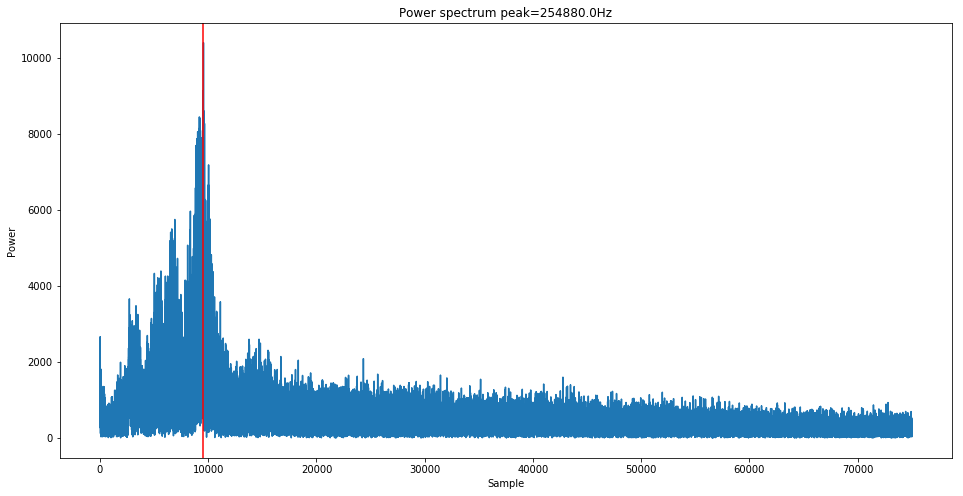

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(pw_spectrum)
plt.axvline(x=i, color='r')
plt.title(f'Power spectrum peak={peak_freq}Hz')
plt.ylabel('Power')
plt.xlabel('Sample')
plt.show()

## Playground with HPS method

In [17]:
corr = fftconvolve(data, data[::-1], mode='full')
corr = corr[len(corr)//2:]

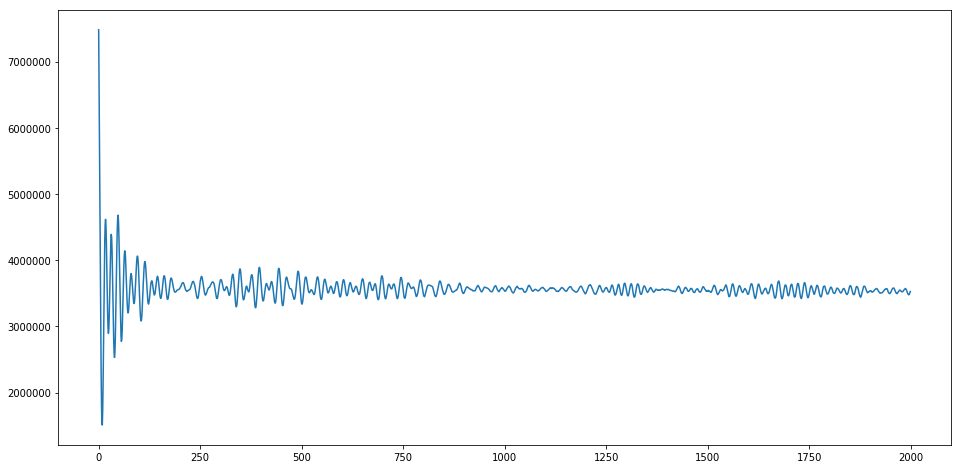

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(corr[:2000])
plt.show()

In [19]:
d = diff(corr)

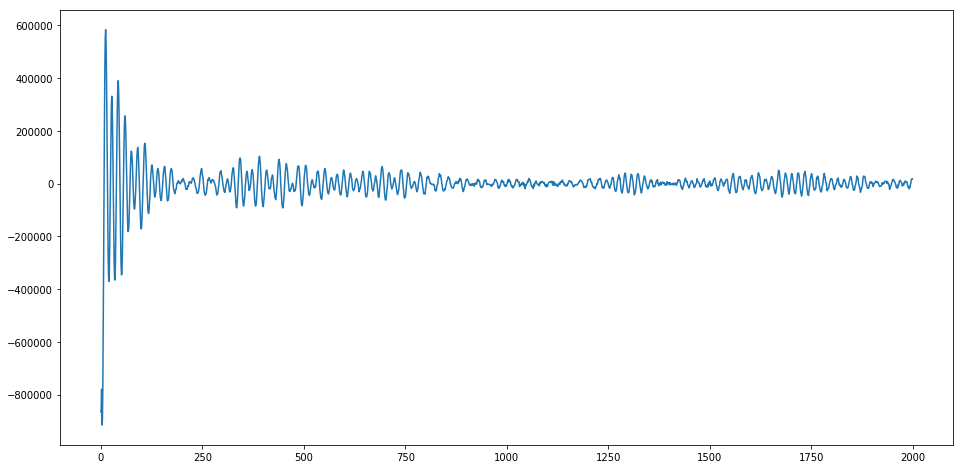

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(d[:2000])
plt.show()

In [27]:
start = np.nonzero(d > 0)[0][0]

In [28]:
start

9

In [29]:
peak = argmax(corr[start:]) + start

In [30]:
peak_freq = fs / peak

In [31]:
peak_freq

83333.33333333333